# Determinación de la vida media del $\mu$

En el laboratorio hemos dejado toda la noche midiendo con la configuración de trigger ABC-noD. De esta forma, registraremos la medida de muones que atraviesen los 3 primeros detectores y se frenen en la plancha de Pb. Una vez esto ocurre, medimos el máximo de potencial para cualquier detector y determinamos el tiempo realizando un ajuste parabólico, utilizando el máximo medido y sus dos puntos más próximos.

********************** revisar esto !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Una vez teniendo los tiempos característicos y el número de cuentas, ajustaremos los datos obtenidos a la ley exponencial de desintegración:

$$ N = N_{0} e^{-t/\tau} $$

donde $\tau$ será la vida media del $\mu$

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize as so
import scipy.special as se #para el factorial
import pandas as pd
from decimal import * #para las cifras significativas
from time import time
from scipy import stats #para el test de chi

Leemos los datos desde el archivo .txt

In [2]:
def leerArchivo(archivo):
    completo = open(archivo, 'r')
    tiempos = []
    datos = []
    contador = 0
    for linea in completo: #recorremos cada línea del archivo
        if len(linea) == 1: #len cuenta los bytes de cada linea: si tiene 1 byte es porque cuenta el salto de linea como \n
            continue
        else: #en otro caso, será algún dato de interés
            numero_elementos = linea.split() #guardamos los elementos de la línea
            if len(numero_elementos) == 1: #si hay un solo elemento, será el tiempo unix
                tiempos.append(numero_elementos)
                contador += 1
            else: #en otro caso, será alguno de los otros datos
                datos.append(numero_elementos)
                contador += 1
    
    #el resultado de este bucle es una lista de listas, lo cual no nos interesa porque queremos trabajar con elementos que sean números
    tamaño = len(tiempos)
    tiempos_unix = [] #almacenamos aquí el tiempo unix
    for i in range(tamaño):
        tiempos_unix.append(int(tiempos[i][0]))
    
    #leemos también los datos de los tiempos en ns y las amplitudes de la señal
    tiempos_volt = [] #tiempos de registro de amplitudes de señal (cada 4 ns)
    numero_iteraciones = len(datos)
    for j in range(numero_iteraciones):
        tiempos_volt.append(int(datos[j][0]))
    medidasA = [] #amplitudes detector A
    for k in range(numero_iteraciones):
        medidasA.append(int(datos[k][1]))
    medidasB = [] #amplitudes detector B
    for l in range(numero_iteraciones):
        medidasB.append(int(datos[l][2]))
    medidasC = [] #amplitudes detector C
    for m in range(numero_iteraciones):
        medidasC.append(int(datos[m][3]))
    medidasD = [] #amplitudes detector D
    for n in range(numero_iteraciones):
        medidasD.append(int(datos[n][4]))
    
    return tiempos_unix, tiempos_volt, medidasA, medidasB, medidasC, medidasD, datos

Primero usaremos los datos recogidos por nosotros. Después usaremos los proporcionados por el profesor para distintos umbrales, donde podremos realizar un estudio dependiendo de esta última variable.

In [3]:
medidas_mu = leerArchivo('datos_lab_21a22Feb.txt')[6]
"""
tiempos_completo = leerArchivo('VidaMediaMuonPlomo.txt')[1]
medA = leerArchivo('VidaMediaMuonPlomo.txt')[2]
medB = leerArchivo('VidaMediaMuonPlomo.txt')[3]
medC = leerArchivo('VidaMediaMuonPlomo.txt')[4]
medD = leerArchivo('VidaMediaMuonPlomo.txt')[5]
"""
unix = leerArchivo('datos_lab_21a22Feb.txt')[0]

In [4]:
#la función nos devuelve listas con strings, así que pasamos los elementos a float
for i in range(len(medidas_mu)):
    for j in range(len(medidas_mu[i])):
        if type(medidas_mu[i][j]) == str:
            medidas_mu[i][j] = float(medidas_mu[i][j])

In [5]:
"""
#guardamos en un array solo las filas posteriores al trigger (t = 40 ns)
medidas = []
for i in range(len(medidas_mu)):
    if medidas_mu[i][0] >= 40:
        medidas.append(medidas_mu[i])"""

'\n#guardamos en un array solo las filas posteriores al trigger (t = 40 ns)\nmedidas = []\nfor i in range(len(medidas_mu)):\n    if medidas_mu[i][0] >= 40:\n        medidas.append(medidas_mu[i])'

In [6]:
#número de triggers = número de tiempos unix
n_sep = len(unix)
#creamos una lista de n_sep listas vacías donde almacenaremos los datos de cada medida
datos = [[] for k in range(n_sep)]

i = 1
for j in range(len(datos)):
    while medidas_mu[i-1][0] < medidas_mu[i][0] and i < (len(medidas_mu)-1):
        datos[j].append(medidas_mu[i-1])
        i += 1
    else:
        i += 1

En primer lugar, se dará un mínimo de potencial en los 3 primeros detectores (condición de trigger). A continuación, cuando el muón se detenga en la plancha de plomo y se desintegre, se observará otro mínimo en el detector C (si el muón se frena en la superficie superior del plomo y sale despedido hacia arriba) o en el detector D (si se frena en la parte inferior y el electrón sale hacia abajo).

Este segundo pulso no tiene por qué verse, de hecho observando las series de datos obtenidas en muy pocas se logra identificar. La razón es que el electrón puede quedarse en el mismo plomo si el muón se frena en un lugar intermedio de su grosor, puede salir despedido hacia algún lateral....

En la siguiente caja de código calcularemos los valores mínimos del potencial y su tiempo. Este tiempo será el que usaremos como referencia para calcular la vida media del $\mu$, siendo esta la diferencia entre el tiempo calculado y el tiempo asociado al pulso detectado por la desintegración del electrón.

In [7]:
start_time = time()

t_min_A_trigger = []
t_min_A_desint = []
V_min_A_trigger = []
V_min_A_desint = []

t_min_B_trigger = []
t_min_B_desint = []
V_min_B_trigger = []
V_min_B_desint = []

t_min_C_trigger = []
t_min_C_desint = []
V_min_C_trigger = []
V_min_C_desint= []

t_min_D_trigger = []
t_min_D_desint = []
V_min_D_trigger = []
V_min_D_desint = []

indices_mu = []

def parabola(x, a, b, c):
    return a*x**2 + b*x + c

for i in range(len(datos)):
    
    t = []
    
    for j in range(len(datos[i])):
        t.append(datos[i][j][0])
    
    for k in range(1,len(t)):
        if t[k]-t[k-1] > 50 and t[k] > 40:
            
            indices_mu.append(i)
            
            trigger = []
            desint = []
            
            l = 1
            while datos[i][l][0] - datos[i][l-1][0] == 4: #hacer el código de nuevo, quitar los det y usar los datos trigger y desint separados para analizar los mínimos
                trigger.append(datos[i][l-1])
                l += 1
            else:
                for m in range(len(datos[i])-l):
                    desint.append(datos[i][m+l])
                l += 1
            
            ########################################
            detA_trigger = []
            detB_trigger = []
            detC_trigger = []
            detD_trigger = []
    
            for n in range(len(trigger)):
                detA_trigger.append(trigger[n][1])
                detB_trigger.append(trigger[n][2])
                detC_trigger.append(trigger[n][3])
                detD_trigger.append(trigger[n][4])
            ########################################   
            detA_desint = []
            detB_desint = []
            detC_desint = []
            detD_desint = []
            
            for p in range(len(desint)):
                detA_desint.append(desint[p][1])
                detB_desint.append(desint[p][2])
                detC_desint.append(desint[p][3])
                detD_desint.append(desint[p][4])
            #######################################
            
            t_aux = np.linspace(30,10000,100000)
            
            ###############################################################################################
            indice_min_A_trigger = detA_trigger.index(min(detA_trigger))
            tA_trigger = [t[indice_min_A_trigger-1], t[indice_min_A_trigger], t[indice_min_A_trigger+1]]
            ajusteA_trigger = [detA_trigger[indice_min_A_trigger-1], detA_trigger[indice_min_A_trigger], detA_trigger[indice_min_A_trigger+1]]
            solA_trigger, covA_trigger = so.curve_fit(parabola, tA_trigger, ajusteA_trigger)
            aA_trigger = solA_trigger[0] ; bA_trigger = solA_trigger[1] ; cA_trigger = solA_trigger[2]
            VA_trigger = aA_trigger*t_aux**2 + bA_trigger*t_aux + cA_trigger
            V_min_A_trigger.append(min(VA_trigger))
            t_min_A_trigger.append(t_aux[list(VA_trigger).index(min(VA_trigger))])
            
            indice_min_A_desint = detA_desint.index(min(detA_desint))
            if indice_min_A_desint == (len(detA_desint)-1):
                detA_desint.append(detA_desint[indice_min_A_desint-1])
                t.append(t[indice_min_A_desint+len(detA_trigger)] + t[indice_min_A_desint+len(detA_trigger)] - t[indice_min_A_desint-1+len(detA_trigger)])
            if abs(min(detA_desint)) > 50 and len(detA_desint) > 2: #añadimos una cota mínima para considerarlo detección
                tA_desint = [t[indice_min_A_desint-1+len(detA_trigger)], t[indice_min_A_desint+len(detA_trigger)], t[indice_min_A_desint+1+len(detA_trigger)]]
                ajusteA_desint = [detA_desint[indice_min_A_desint-1], detA_desint[indice_min_A_desint], detA_desint[indice_min_A_desint+1]]
                solA_desint, covA_desint = so.curve_fit(parabola, tA_desint, ajusteA_desint)
                aA_desint = solA_desint[0] ; bA_desint = solA_desint[1] ; cA_desint = solA_desint[2]
                VA_desint = aA_desint*t_aux**2 + bA_desint*t_aux + cA_desint
                V_min_A_desint.append(min(VA_desint))
                t_min_A_desint.append(t_aux[list(VA_desint).index(min(VA_desint))])
            else:
                V_min_A_desint.append(0)
                t_min_A_desint.append(t_aux[list(VA_trigger).index(min(VA_trigger))]) #si no hay otro mínimo, añadimos el tiempo del trigger para que tau sea nulo
            
            ###############################################################################################
            
            indice_min_B_trigger = detB_trigger.index(min(detB_trigger))
            tB_trigger = [t[indice_min_B_trigger-1], t[indice_min_B_trigger], t[indice_min_B_trigger+1]]
            ajusteB_trigger = [detB_trigger[indice_min_B_trigger-1], detB_trigger[indice_min_B_trigger], detB_trigger[indice_min_B_trigger+1]]
            solB_trigger, covB_trigger = so.curve_fit(parabola, tB_trigger, ajusteB_trigger)
            aB_trigger = solB_trigger[0] ; bB_trigger = solB_trigger[1] ; cB_trigger = solB_trigger[2]
            VB_trigger = aB_trigger*t_aux**2 + bB_trigger*t_aux + cB_trigger
            V_min_B_trigger.append(min(VB_trigger))
            t_min_B_trigger.append(t_aux[list(VB_trigger).index(min(VB_trigger))])
            
            indice_min_B_desint = detB_desint.index(min(detB_desint))
            if indice_min_B_desint == (len(detB_desint)-1):
                detB_desint.append(detB_desint[indice_min_B_desint-1])
                t.append(t[indice_min_B_desint+len(detB_trigger)] + t[indice_min_B_desint+len(detB_trigger)] - t[indice_min_B_desint-1+len(detB_trigger)])
            if abs(min(detB_desint)) > 50 and len(detB_desint) > 2: #añadimos una cota mínima para considerarlo detección
                tB_desint = [t[indice_min_B_desint-1+len(detB_trigger)], t[indice_min_B_desint+len(detB_trigger)], t[indice_min_B_desint+1+len(detB_trigger)]]
                ajusteB_desint = [detB_desint[indice_min_B_desint-1], detB_desint[indice_min_B_desint], detB_desint[indice_min_B_desint+1]]
                solB_desint, covB_desint = so.curve_fit(parabola, tB_desint, ajusteB_desint)
                aB_desint = solB_desint[0] ; bB_desint = solB_desint[1] ; cB_desint = solB_desint[2]
                VB_desint = aB_desint*t_aux**2 + bB_desint*t_aux + cB_desint
                V_min_B_desint.append(min(VB_desint))
                t_min_B_desint.append(t_aux[list(VB_desint).index(min(VB_desint))])
            else:
                V_min_B_desint.append(0)
                t_min_B_desint.append(t_aux[list(VB_trigger).index(min(VB_trigger))]) #si no hay otro mínimo, añadimos el tiempo del trigger para que tau sea nulo
            
            ###############################################################################################
            
            indice_min_C_trigger = detC_trigger.index(min(detC_trigger))
            tC_trigger = [t[indice_min_C_trigger-1], t[indice_min_C_trigger], t[indice_min_C_trigger+1]]
            ajusteC_trigger = [detC_trigger[indice_min_C_trigger-1], detC_trigger[indice_min_C_trigger], detC_trigger[indice_min_C_trigger+1]]
            solC_trigger, covC_trigger = so.curve_fit(parabola, tC_trigger, ajusteC_trigger)
            aC_trigger = solC_trigger[0] ; bC_trigger = solC_trigger[1] ; cC_trigger = solC_trigger[2]
            VC_trigger = aC_trigger*t_aux**2 + bC_trigger*t_aux + cC_trigger
            V_min_C_trigger.append(min(VC_trigger))
            t_min_C_trigger.append(t_aux[list(VC_trigger).index(min(VC_trigger))])
            
            indice_min_C_desint = detC_desint.index(min(detC_desint))
            if indice_min_C_desint == (len(detC_desint)-1):
                detC_desint.append(detC_desint[indice_min_C_desint-1])
                t.append(t[indice_min_C_desint+len(detC_trigger)] + t[indice_min_C_desint+len(detC_trigger)] - t[indice_min_C_desint-1+len(detC_trigger)])
            if abs(min(detC_desint)) > 50 and len(detC_desint) > 2: #añadimos una cota mínima para considerarlo detección
                tC_desint = [t[indice_min_C_desint-1+len(detC_trigger)], t[indice_min_C_desint+len(detC_trigger)], t[indice_min_C_desint+1+len(detC_trigger)]]
                ajusteC_desint = [detC_desint[indice_min_C_desint-1], detC_desint[indice_min_C_desint], detC_desint[indice_min_C_desint+1]]
                solC_desint, covC_desint = so.curve_fit(parabola, tC_desint, ajusteC_desint)
                aC_desint = solC_desint[0] ; bC_desint = solC_desint[1] ; cC_desint = solC_desint[2]
                VC_desint = aC_desint*t_aux**2 + bC_desint*t_aux + cC_desint
                V_min_C_desint.append(min(VC_desint))
                t_min_C_desint.append(t_aux[list(VC_desint).index(min(VC_desint))])
            else:
                V_min_C_desint.append(0)
                t_min_C_desint.append(t_aux[list(VC_trigger).index(min(VC_trigger))]) #si no hay otro mínimo, añadimos el tiempo del trigger para que tau sea nulo
            
            ###############################################################################################
            
            #no tiene sentido analizar D en la región de trigger porque nunca va a detectar
            
            """indice_min_indice_min_D_trigger = detD_trigger.index(min(detD_trigger))
            tD_trigger = [t[indice_min_D_trigger-1], t[indice_min_D_trigger], t[indice_min_D_trigger+1]]
            ajusteD_trigger = [detD_trigger[indice_min_D_trigger-1], detD_trigger[indice_min_D_trigger], detD_trigger[indice_min_D_trigger+1]]
            solD_trigger, covD_trigger = so.curve_fit(parabola, tD_trigger, ajusteD_trigger)
            aD_trigger = solD_trigger[0] ; bD_trigger = solD_trigger[1] ; cD_trigger = solD_trigger[2]
            VD_trigger = aD_trigger*t_aux**2 + bD_trigger*t_aux + cD_trigger
            V_min_D_trigger.append(min(VD_trigger))
            t_min_D_trigger.append(t_aux[list(VD_trigger).index(min(VD_trigger))])"""
            
            #añadimos el tiempo del mínimo con más amplitud de los 3 detectores superiores
            if V_min_A_trigger < V_min_B_trigger and V_min_A_trigger < V_min_C_trigger:
                tD_trigger = tA_trigger
                t_min_D_trigger.append(t_aux[list(VA_trigger).index(min(VA_trigger))])
            elif V_min_B_trigger < V_min_A_trigger and V_min_B_trigger < V_min_C_trigger:
                tD_trigger = tB_trigger
                t_min_D_trigger.append(t_aux[list(VB_trigger).index(min(VB_trigger))])
            elif V_min_C_trigger < V_min_A_trigger and V_min_C_trigger < V_min_B_trigger:
                tD_trigger = tC_trigger
                t_min_D_trigger.append(t_aux[list(VC_trigger).index(min(VC_trigger))])
                        
            indice_min_D_desint = detD_desint.index(min(detD_desint))
            if indice_min_D_desint == (len(detD_desint)-1):
                detD_desint.append(detD_desint[indice_min_D_desint-1])
                t.append(t[indice_min_D_desint+len(detD_trigger)] + t[indice_min_D_desint+len(detD_trigger)] - t[indice_min_D_desint-1+len(detD_trigger)])
            if abs(min(detD_desint)) > 50 and len(detD_desint) > 2: #añadimos una cota mínima para considerarlo detección
                tD_desint = [t[indice_min_D_desint-1+len(detD_trigger)], t[indice_min_D_desint+len(detD_trigger)], t[indice_min_D_desint+1+len(detD_trigger)]]
                ajusteD_desint = [detD_desint[indice_min_D_desint-1], detD_desint[indice_min_D_desint], detD_desint[indice_min_D_desint+1]]
                solD_desint, covD_desint = so.curve_fit(parabola, tD_desint, ajusteD_desint)
                aD_desint = solD_desint[0] ; bD_desint = solD_desint[1] ; cD_desint = solD_desint[2]
                VD_desint = aD_desint*t_aux**2 + bD_desint*t_aux + cD_desint
                V_min_D_desint.append(min(VD_desint))
                t_min_D_desint.append(t_aux[list(VD_desint).index(min(VD_desint))])
            else: #si no hay otro mínimo, añadimos el tiempo del trigger para que tau sea nulo
                V_min_D_desint.append(0)
                if V_min_A_trigger < V_min_B_trigger and V_min_A_trigger < V_min_C_trigger:
                    t_min_D_desint.append(t_aux[list(VA_trigger).index(min(VA_trigger))])
                elif V_min_B_trigger < V_min_A_trigger and V_min_B_trigger < V_min_C_trigger:
                    t_min_D_desint.append(t_aux[list(VB_trigger).index(min(VB_trigger))])
                elif V_min_C_trigger < V_min_A_trigger and V_min_C_trigger < V_min_B_trigger:
                    t_min_D_desint.append(t_aux[list(VC_trigger).index(min(VC_trigger))])

            ###############################################################################################
end_time = time()
print('tiempo de ejecución: ', end_time - start_time)

C:\Users\sergi\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


tiempo de ejecución:  235.51967549324036


In [8]:
#Definimos los tiempos de vida media como la diferencia entre mínimos
            
maximos_trigger = []
maximos_desint = []

tauA = []
tauB = []
tauC = []
tauD = []
            
detecciones = []
            
for q in range(len(indices_mu)): #número de bloques de datos en los que se ha detectado el producto de la desintegración
    #maximos_trigger.append(min(V_min_A_trigger[q], V_min_B_trigger[q], V_min_B_trigger[q]))
    #maximos_desint.append(min(V_min_A_desint[q], V_min_B_desint[q], V_min_C_desint[q], V_min_D_desint[q]))
    
    tauA.append(abs(t_min_A_desint[q] - t_min_A_trigger[q]))
    tauB.append(abs(t_min_B_desint[q] - t_min_B_trigger[q]))
    tauC.append(abs(t_min_C_desint[q] - t_min_C_trigger[q]))
    tauD.append(abs(t_min_D_desint[q] - t_min_D_trigger[q]))

#### Analizamos los tiempos de vida media calculados

En primer lugar, limpiamos los datos quitando tanto los valores nulos como los superiores a una cota que establecemos visualizando el histograma completo. A continuación, presentamos un histograma con los resultados.

In [9]:
numero_ceros_A = tauA.count(0)
for i in range(numero_ceros_A):
    tauA.remove(0.0)
for i in tauA:
    if i > 9500:
        tauA.remove(i)

numero_ceros_B = tauB.count(0)
for i in range(numero_ceros_B):
    tauB.remove(0.0)
for i in tauB:
    if i > 9500:
        tauB.remove(i)
    
numero_ceros_C = tauC.count(0)
for i in range(numero_ceros_C):
    tauC.remove(0.0)
for i in tauC:
    if i > 9500:
        tauC.remove(i)

numero_ceros_D = tauD.count(0)
for i in range(numero_ceros_D):
    tauD.remove(0.0)
for i in tauD:
    if i > 9500:
        tauD.remove(i)

In [139]:
len(tauD)

273

#### suma a todos los detectores

In [45]:
tau = []
for i in range(len(tauA)):
    tau.append(tauA[i])
for i in range(len(tauB)):
    tau.append(tauB[i])
for i in range(len(tauC)):
    tau.append(tauC[i])
for i in range(len(tauD)):
    tau.append(tauD[i])

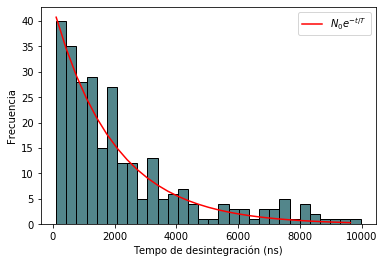

chi2 =  1.4894694107023854
p =  0.9999999999999075
grados libertad =  28
-----------------------
tau =  1970.0464461656343
u(tau) =  158.6820619694357


In [133]:
n_bins = 30
frec, xbins, patches = plt.hist(tauD, histtype='bar', color='#53868B', edgecolor='black', bins=n_bins) #density='norm' normaliza la distribución
u = np.sqrt(frec)

#return de plt.hist: n -> the values of the histogram bins ; bins -> the edges of the bins

#labels, counts = np.unique(tau, return_counts=True)

#para centrar las barras
"""ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
ticklabels = [i for i in range(n_bins)]
plt.xticks(ticks, ticklabels)"""

modulo = 0
for i in range(1,len(xbins[:-1])):
    modulo = modulo + (xbins[i]-xbins[i-1])*frec[i]

def exponencial(t, T, N0):
    return N0*np.exp(-t/T)

Ttest = sum(xbins[:-1]*frec)/sum(frec)
N0test = 20
ptest = [Ttest, N0test]

sol , cov = so.curve_fit(exponencial, xbins[:-1], frec, p0=ptest)
T = sol[0]
N0 = sol[1]
uT = np.sqrt(cov[0][0])

y = exponencial(xbins[:-1], T, N0)

plt.plot(xbins[:-1], y, c='red', label='$N_{0} e^{-t/T}$ ')

plt.legend(loc='best')
plt.xlabel('Tempo de desintegración (ns)')
plt.ylabel('Frecuencia')
plt.title('')
#plt.errorbar(ticks, frec, xerr=None, yerr=u, fmt='.', color='k', ecolor='k', elinewidth=1, capsize=3)
#plt.savefig('T.pdf')

plt.show()

#TEST DE CHI 2

n_parametros = 2
n_grados_libertad = len(xbins[:-1]) - n_parametros

def chi_squared(x, y_experimental, uy_experimental, fun, coef):
    y_fit = fun(x, *coef)
    suma_desv = 0
    residuals = np.zeros(len(y_experimental))
    for i in range(len(x)-1):
        residuals[i] = y_experimental[i]-y_fit[i]
        suma_desv += residuals[i]**2/(uy_experimental[i])**2
    chi2_red = suma_desv/(len(x)-len(coef))
    return residuals, suma_desv, chi2_red
chi2 = chi_squared(xbins[:-1], frec, u, exponencial, sol)[2]

def p_value(chi, df):
    return 1 - stats.chi2.cdf(chi, df)
p = p_value(chi2, n_grados_libertad)

print('chi2 = ', chi2)
print('p = ', p)
print('grados libertad = ', n_grados_libertad)
print('-----------------------')
print('tau = ', T)
print('u(tau) = ', uT)

Explicación sobre p y el intervalo de confianza:

Para determinar si las variables son independientes, compare el valor p con el nivel de significancia. Por lo general, un nivel de significancia (denotado como α o alfa) de 0.05 funciona adecuadamente. Un nivel de significancia de 0.05 indica un riesgo de 5% de concluir que existe una asociación entre las variables cuando no hay una asociación real.

Valor p ≤ α: Las variables tienen una asociación estadísticamente significativa (Rechazar H0)
Si el valor p es menor que o igual al nivel de significancia, usted rechaza la hipótesis nula y concluye que hay una asociación estadísticamente significativa entre las variables.

Valor p > α: No se puede concluir que las variables están asociadas (No se puede rechazar H0)
Si el valor p es mayor que el nivel de significancia, usted no puede rechazar la hipótesis nula, porque no hay suficiente evidencia para concluir que las variables están asociadas.

In [144]:
T =  np.array([1397,1604,1193,1970])
uT = np.array([438,466,887,237])

In [145]:
T_medio = np.average(T, axis=None, weights=uT, returned=False)
uT_medio = np.sqrt(sum(uT**2)/sum(uT))
print('tau = ', T_medio)
print('u(tau) = ', uT_medio)

tau =  1422.3032544378698
u(tau) =  24.846054615980304


### usar solo el código de arriba para todos los sets de datos !!!!!!!!!!!!!!!!!!!!!!!!!!!!

#### Comparación amplitudes rexistradas por muones y electrones.

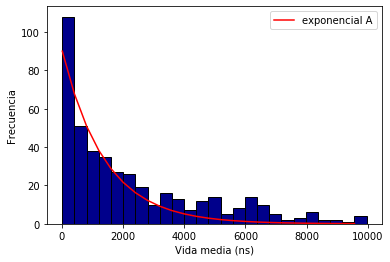

p = 0.0
tau =  1393.0812705943233
u(tau)=  164.98812270722777
N0 =  91.27734691295746
X^2 =  3027253234.31963
chi2 =  3.39971460863715


In [54]:
frecA, xbinsA, _ = plt.hist(tauA, histtype='bar', color='#00008B', edgecolor='black', bins=25) #density='norm' normaliza la distribución
uA = np.sqrt(frecA)

#return de plt.hist: n -> the values of the histogram bins ; bins -> the edges of the bins

#labels_A, counts_A = np.unique(tauA, return_counts=True)

def exponencial(t, T, N0):
    return N0*np.exp(-t/T)

Ttest = 1000
N0test = 20
ptest = [Ttest, N0test]

solA , covA = so.curve_fit(exponencial, xbinsA[:-1], frecA, p0=ptest)
TA = solA[0]
u_TA = np.sqrt(covA[0][0])
N0_A = solA[1]

y_A = exponencial(xbinsA[:-1], TA, N0_A)

plt.plot(xbinsA[:-1], y_A, c='red', label='exponencial A')

plt.legend(loc='best')
plt.xlabel('Vida media (ns)')
plt.ylabel('Frecuencia')
plt.title('')
#plt.xlim(0,300)

plt.show()

#test de chi^2
n_parametros = 2
n_grados_libertad = len(xbinsA[:-1]) - n_parametros
chisq_A, p_A = stats.chisquare(xbinsA[:-1], exponencial(xbinsA[:-1], TA, N0_A), ddof=1)

#ddof: “Delta degrees of freedom” adjustment to the degrees of freedom for the p-value. The p-value is computed using 
#a chi-squared distribution with k - 1 - ddof degrees of freedom, where k is the number of observed frequencies.
#The default value of ddof is 0.
print('p =', p_A)
print('tau = ', TA)
print('u(tau)= ', u_TA)
print('N0 = ', N0_A)
print('X^2 = ', chisq_A)

def chi_squared(x, y_experimental, uy_experimental, fun, coef):
    y_fit = fun(x, *coef)
    suma_desv = 0
    residuals = np.zeros(len(y_experimental))
    for i in range(len(x)-1):
        residuals[i] = y_experimental[i]-y_fit[i]
        suma_desv += residuals[i]**2/(uy_experimental[i])**2
    chi2_red = suma_desv/(len(x)-len(coef))
    return residuals, suma_desv, chi2_red

chi2 = chi_squared(xbinsA[:-1], frecA, uA, exponencial, solA)[2]
print('chi2 = ', chi2)
#p_value = stats.chi2.cdf(chi2, )"""

In [29]:
covA

array([[27221.08063446,  -685.97754119],
       [ -685.97754119,    45.71622824]])

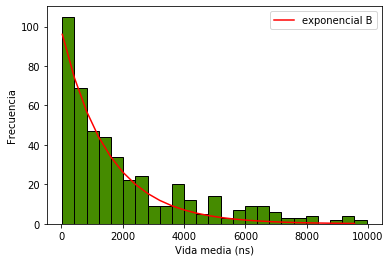

X^2 = 1675326327.893416
X^2 red =  72840275.1258007
p = 0.0
tau =  1519.5598693498064


In [18]:
frecB, xbinsB, _ = plt.hist(tauB, histtype='bar', color='#458B00', edgecolor='black', bins=25) #density='norm' normaliza la distribución

#return de plt.hist: n -> the values of the histogram bins ; bins -> the edges of the bins

#labels_B, counts_B = np.unique(tauB, return_counts=True)

moduloB = 0
for i in range(1,len(xbinsB[:-1])):
    moduloB = moduloB + (xbinsB[i]-xbinsB[i-1])*frecB[i]

def exponencial(t, T, N0):
    return N0*np.exp(-t/T)

Ttest = 1000
N0test = 20
ptest = [Ttest, N0test]

solB , covB = so.curve_fit(exponencial, xbinsB[:-1], frecB, p0=ptest)
TB = solB[0]
N0_B = solB[1]

y_B = exponencial(xbinsB[:-1], TB, N0_B)

plt.plot(xbinsB[:-1], y_B, c='red', label='exponencial B')

plt.legend(loc='best')
plt.xlabel('Vida media (ns)')
plt.ylabel('Frecuencia')
plt.title('')

plt.show()

#test de chi^2
n_parametros = 2
n_grados_libertad = len(xbinsB[:-1]) - n_parametros
chisq_B, p_B = stats.chisquare(xbinsB[:-1], exponencial(xbinsB[:-1], TB, N0_B), ddof=1) #usamos los valores del histograma ?????????
print('X^2 =', chisq_B)
print('X^2 red = ', chisq_B/n_grados_libertad)
print('p =', p_B)
print('tau = ', TB)

In [200]:
solB

array([1630.48685656,   24.46248026])

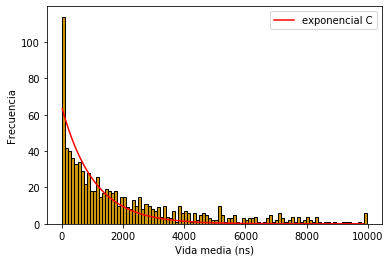

X^2 = 167721407385.2454
p = nan


In [33]:
frecC, xbinsC, _ = plt.hist(tauC, histtype='bar', color='#CD950C', edgecolor='black', bins=100) #density='norm' normaliza la distribución

#return de plt.hist: n -> the values of the histogram bins ; bins -> the edges of the bins

moduloC = 0
for i in range(len(xbinsC[:-1])):
    moduloC = moduloC + xbinsC[i]*frecC[i]
    
TC = []
N0_C = []

def exponencial(t, TC, N0_C):
    return N0_C*np.exp(-t/TC)

Ttest = 1000
N0test = 20
ptest = [Ttest, N0test]

solC , covC = so.curve_fit(exponencial, xbinsC[:-1], frecC, p0=ptest)
TC = solC[0]
N0_C = solC[1]

y_C = exponencial(xbinsC[:-1], TC, N0_C)

plt.plot(xbinsC[:-1], y_C, c='red', label='exponencial C')

plt.legend(loc='best')
plt.xlabel('Vida media (ns)')
plt.ylabel('Frecuencia')
plt.title('')

plt.show()

#test de chi^2
n_parametros = 2
n_grados_libertad = int(moduloC) - n_parametros
chisq_C, p_C = stats.chisquare(xbinsC[:-1], exponencial(xbinsC[:-1], TC, N0_C), ddof = n_grados_libertad) #usamos los valores del histograma ?????????
print('X^2 =', chisq_C)
print('p =', p_C)

In [201]:
solC

array([1720.98217919,   40.76961299])

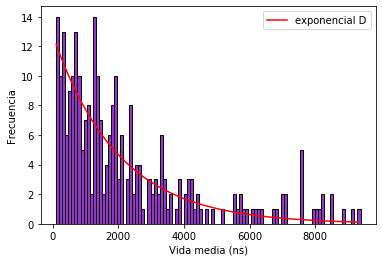

X^2 = 10664508661.996029
p = nan


In [180]:
frecD, xbinsD, _ = plt.hist(tauD, histtype='bar', color='#9A32CD', edgecolor='black', bins=100) #density='norm' normaliza la distribución

#return de plt.hist: n -> the values of the histogram bins ; bins -> the edges of the bins

moduloD = 0
for i in range(len(xbinsD[:-1])):
    moduloD = moduloD + xbinsD[i]*frecD[i]
    
TD = []
N0_D = []

def exponencial(t, TD, N0_D):
    return N0_D*np.exp(-t/TD)

Ttest = 1000
N0test = 20
ptest = [Ttest, N0test]

solD , covD = so.curve_fit(exponencial, xbinsD[:-1], frecD, p0=ptest)
TD = solD[0]
N0_D = solD[1]

y_D = exponencial(xbinsD[:-1], TD, N0_D)

plt.plot(xbinsD[:-1], y_D, c='red', label='exponencial D')

plt.legend(loc='best')
plt.xlabel('Vida media (ns)')
plt.ylabel('Frecuencia')
plt.title('')

plt.show()

#test de chi^2
n_parametros = 2
n_grados_libertad = int(moduloD) - n_parametros
chisq_D, p_D = stats.chisquare(xbinsD[:-1], exponencial(xbinsD[:-1], TD, N0_D), ddof = n_grados_libertad) #usamos los valores del histograma ?????????
print('X^2 =', chisq_D)
print('p =', p_D)


In [202]:
solD

array([1982.88954988,   12.82183003])

#### Amplitudes

Comparemos la distribución de amplitudes en la detección de muones y electrones.

In [147]:
Amplitud_A_desint = []
Amplitud_A_trigger = []
for i in range(len(V_min_A_desint)):
    if V_min_A_desint[i] != 0 and abs(V_min_A_desint[i]) < 20000 and abs(V_min_A_trigger[i]) < 10000:
        Amplitud_A_desint.append(V_min_A_desint[i])
        Amplitud_A_trigger.append(V_min_A_trigger[i])

In [148]:
len(Amplitud_A_trigger)

335

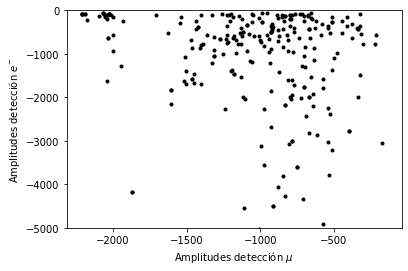

In [149]:
plt.plot(Amplitud_A_trigger, Amplitud_A_desint, 'k.')
plt.xlabel('Amplitudes detección $\mu$')
plt.ylabel('Amplitudes detección $e^{-}$')
plt.ylim(-5000, 0)
plt.show()

In [281]:
######################################### USAR EN ESTUDIO DE AMPLITUDES ####################################################
"""
t_min_A = []
t_min_B = []
t_min_C = []
t_min_D = []

V_min_A = []
V_min_B = []
V_min_C = []
V_min_D = []

indices = []

def parabola(x, a, b, c):
    return a*x**2 + b*x + c

for i in range(len(datos)):
    
    t = []
    
    detA = []
    detB = []
    detC = []
    detD = []
    
    for j in range(len(datos[i])):
        t.append(datos[i][j][0])
        detA.append(datos[i][j][1])
        detB.append(datos[i][j][2])
        detC.append(datos[i][j][3])
        detD.append(datos[i][j][4])
    
    for k in range(1,len(t)):
        if t[k]-t[k-1] != 4:
            
            indices.append(i)
            
            indice_min_A = detA.index(min(detA))
            indice_min_B = detB.index(min(detB))
            indice_min_C = detC.index(min(detC))
            indice_min_D = detD.index(min(detD))

            lA = indice_min_A
            tA = [t[lA-1], t[lA], t[lA+1]]
            lB = indice_min_B
            tB = [t[lB-1], t[lB], t[lB+1]]
            lC = indice_min_C
            tC = [t[lC-1], t[lC], t[lC+1]]
            lD = indice_min_D
            tD = [t[lD-1], t[lD], t[lD+1]]

            ajusteA = [detA[lA-1], detA[lA], detA[lA+1]]
            ajusteB = [detB[lB-1], detB[lB], detB[lB+1]]
            ajusteC = [detC[lC-1], detC[lC], detC[lC+1]]
            ajusteD = [detD[lD-1], detD[lD], detD[lD+1]]

            solA, covA = so.curve_fit(parabola, tA, ajusteA)
            aA = solA[0] ; bA = solA[1] ; cA = solA[2]
            solB, covB = so.curve_fit(parabola, tB, ajusteB)
            aB = solB[0] ; bB = solB[1] ; cB = solB[2]
            solC, covC = so.curve_fit(parabola, tC, ajusteC)
            aC = solC[0] ; bC = solC[1] ; cC = solC[2]

            if ajusteD[1] > 0:
                solD, covD = so.curve_fit(parabola, tD, ajusteD)
                aD = solD[0] ; bD = solD[1] ; cD = solD[2]
            else:
                aD = 0 ; bD = 0 ; cD = 0

            t_aux = np.linspace(30,100,1000)

            VA = aA*t_aux**2 + bA*t_aux + cA
            VB = aB*t_aux**2 + bB*t_aux + cB
            VC = aC*t_aux**2 + bC*t_aux + cC
            VD = aD*t_aux**2 + bD*t_aux + cD

            V_min_A.append(min(VA))
            V_min_B.append(min(VB))
            V_min_C.append(min(VC))
            V_min_D.append(min(VD))

            t_min_A.append(t_aux[list(VA).index(min(VA))])
            t_min_B.append(t_aux[list(VB).index(min(VB))])
            t_min_C.append(t_aux[list(VC).index(min(VC))])
            t_min_D.append(t_aux[list(VD).index(min(VD))]) 
"""